In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

In [82]:
df = pd.read_csv('DMC FAHU B1 0424.csv')
df.describe()

,DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor,DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sp,DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd
count,8639.000000,8639.000000,8639.000000
mean,23.401851,19.938998,24.139244
std,4.724458,2.823201,30.944107
min,12.143188,15.000000,0.000000
25%,21.573312,17.000000,0.000000
50%,22.584522,22.000000,13.628800
75%,27.159395,22.000000,34.261800
max,33.617191,22.000000,100.000000


In [83]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full = df.iloc[:,1:-1].to_numpy()
y = df.iloc[:,3:]
y_full = np.ravel(y)
n_samples, n_features = X_full.shape



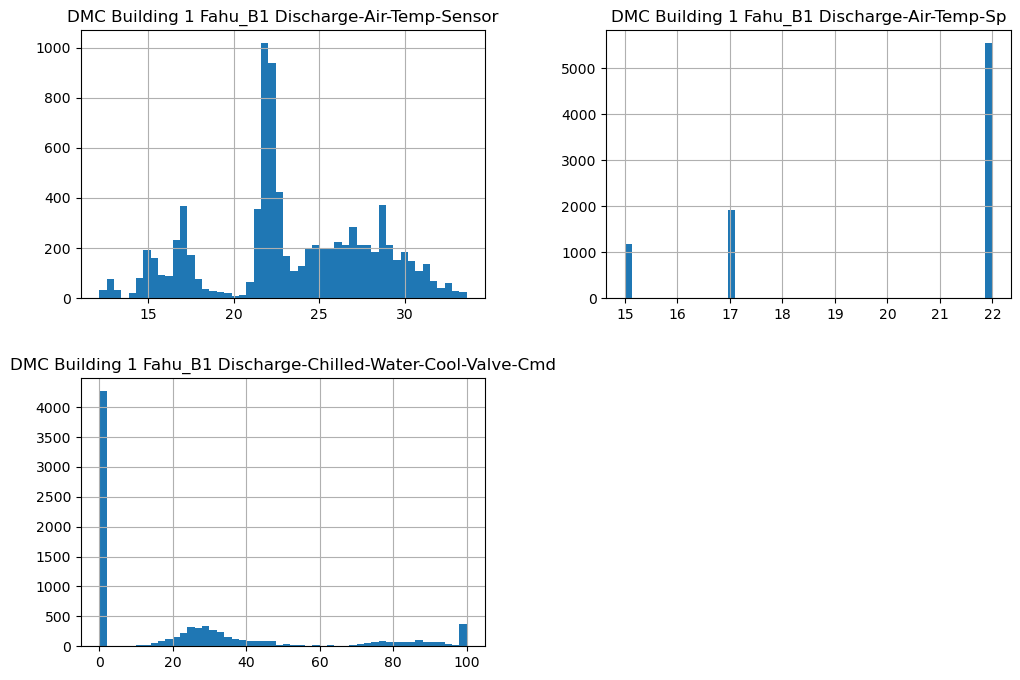

In [84]:
df.hist(bins=50, figsize=(12,8))
plt.show()

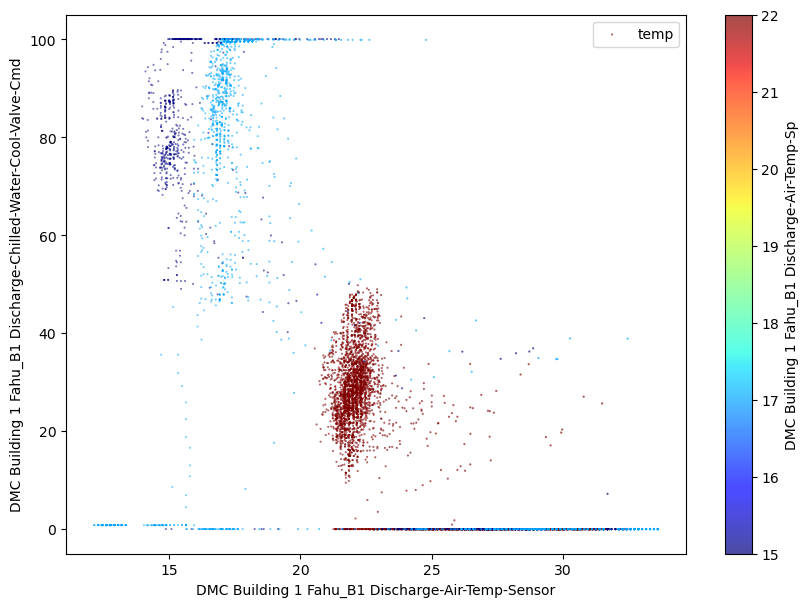

In [85]:
df.plot(kind="scatter", x="DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor",y="DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd", c="DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sp", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7), s=df['DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor']/100, label="temp", alpha=0.7)
plt.show()

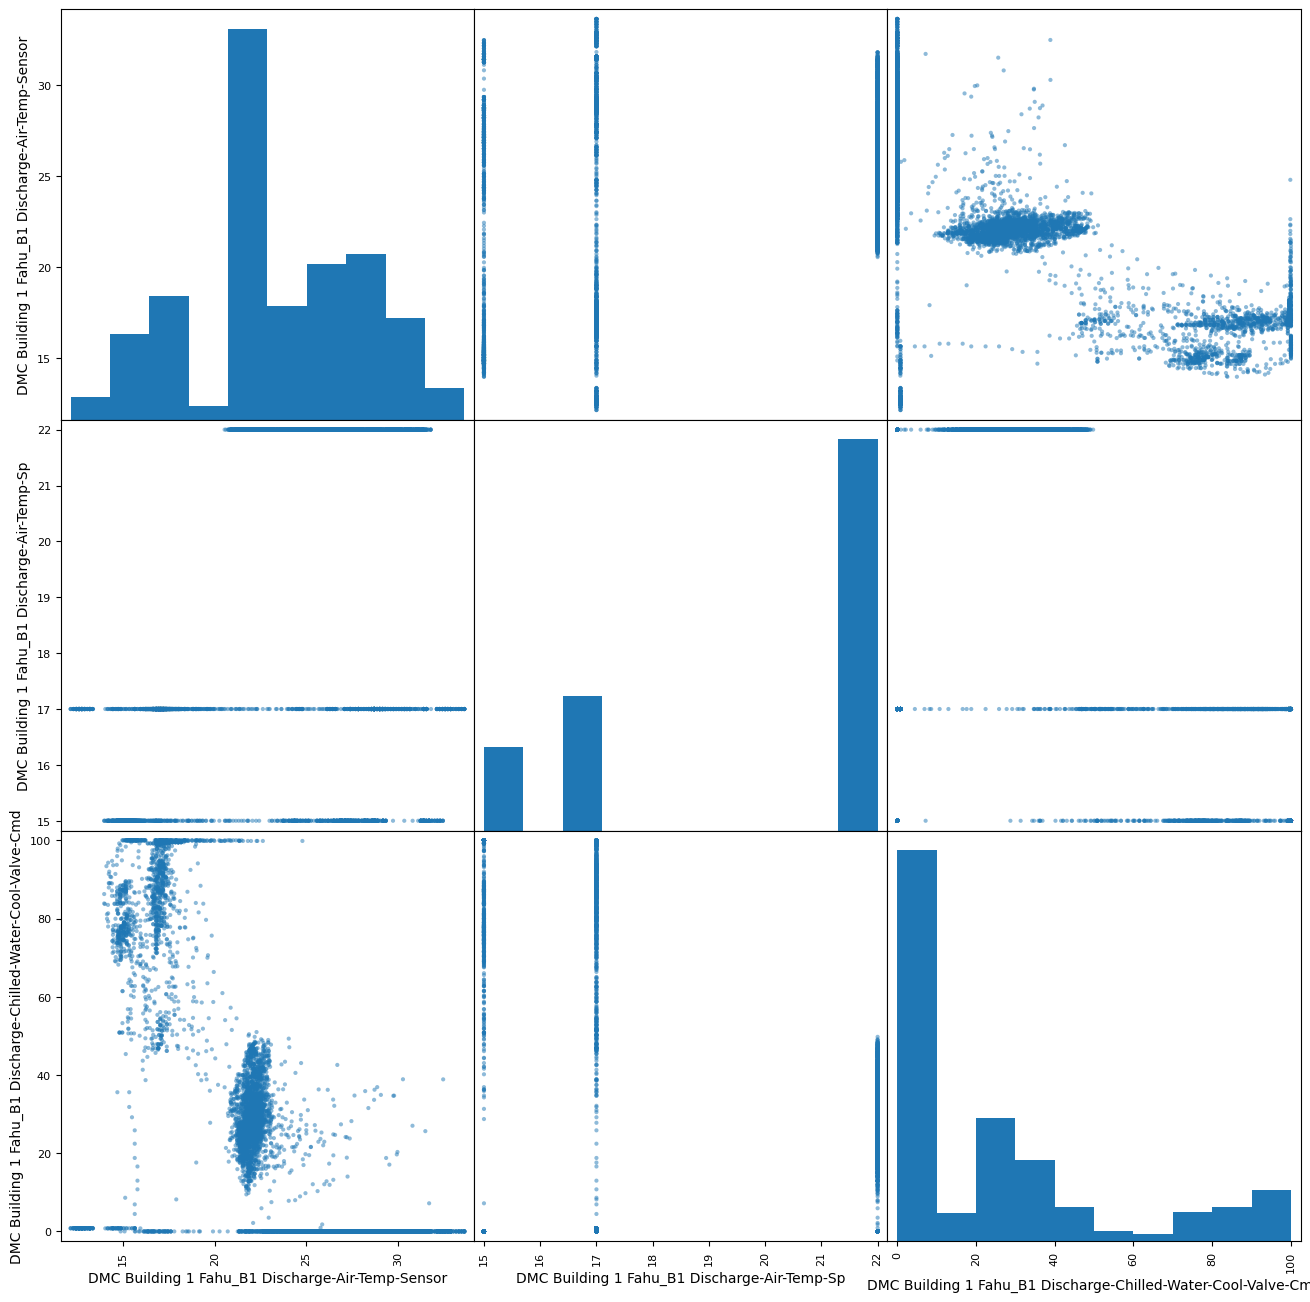

In [86]:
attributes = ['DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor', 'DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sp', 'DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd']
scatter_matrix(df[attributes], figsize=(16,16))
plt.show()

In [87]:
df1 = df.iloc[:,1:]
corr = df1.corr()
corr['DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd'].sort_values(ascending=True)

DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor                -0.745617
DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sp                    -0.400565
DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd    1.000000
Name: DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd, dtype: float64

In [88]:
df.isna().sum()

Timestamp                                                        0
DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor                 0
DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sp                     0
DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd    0
dtype: int64

In [89]:
df.dtypes

Timestamp                                                         object
DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sensor                 float64
DMC Building 1 Fahu_B1 Discharge-Air-Temp-Sp                       int64
DMC Building 1 Fahu_B1 Discharge-Chilled-Water-Cool-Valve-Cmd    float64
dtype: object

In [90]:
# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

In [92]:
# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

In [93]:
# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

In [94]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()

In [95]:
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)


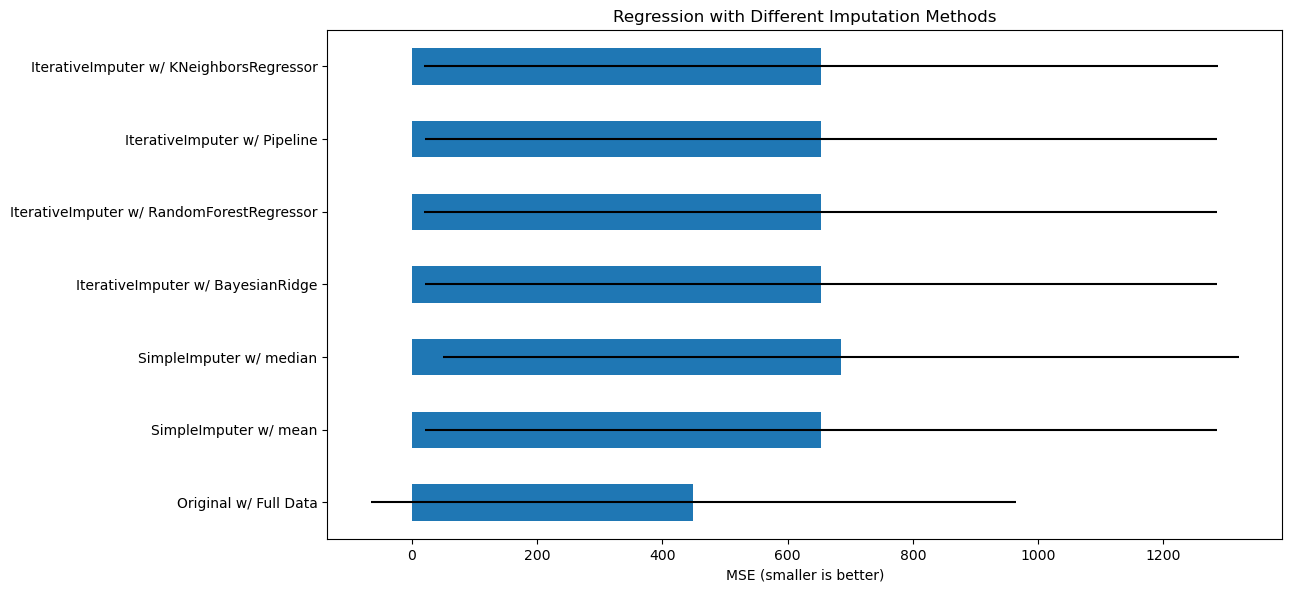

In [97]:
# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()